### Marie Ernst (Matrikelnummer: 11590905)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

# Daten einlesen

In [ ]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

In [ ]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

In [ ]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

## Split

In [ ]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

data = data[data ['Open']!=0]
data = data[data ['Sales']>0]
#data = data[data ['StateHoliday']!=1]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

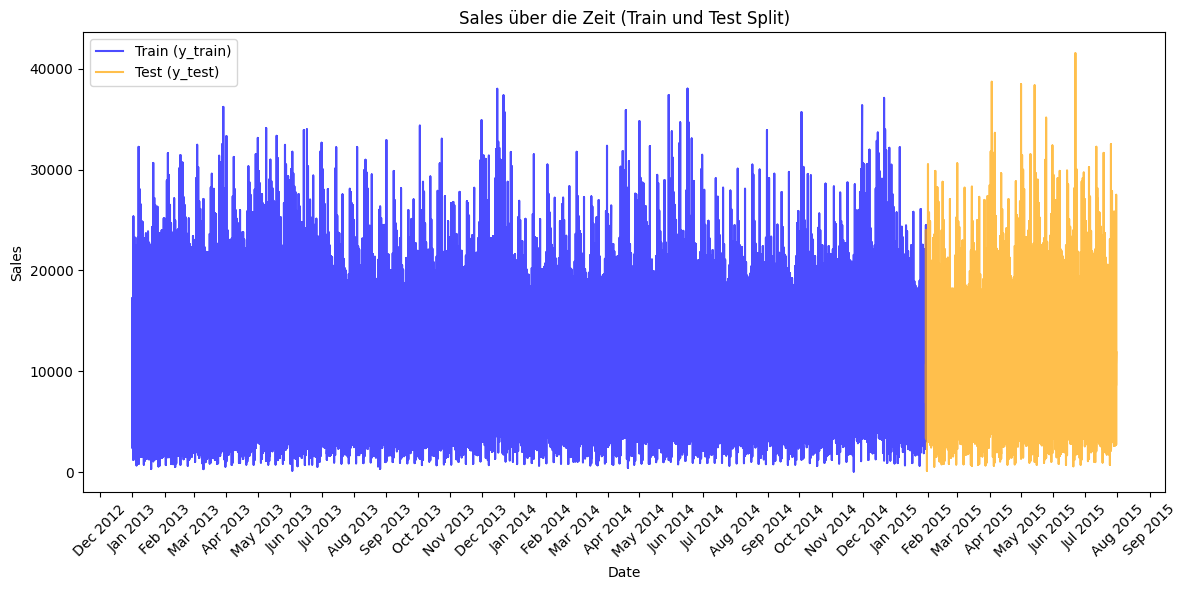

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Konvertiere die 'Date'-Spalte in datetime mit der .loc Methode
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

# Liniendiagramm erstellen, um die wahren Sales in y_train und y_test zu visualisieren
plt.figure(figsize=(12, 6))

# Plot für die Trainingsdaten (y_train)
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='blue', alpha=0.7)

# Plot für die Testdaten (y_test)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='orange', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

# X-Achse mit Datumsformatierung (Monat und Jahr)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Drehe die x-Achsenbeschriftung für bessere Lesbarkeit

# Legende
plt.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

## Metrik

In [ ]:
# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung - Timeseries

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Preprocessing

In [ ]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

# RandomForestRegression

Der RandomForestRegressor gehört zu den gängigsten Machine-Learning-Modellen zur Vorhersage kontinuierlicher Werte. Er basiert auf der Methode des Random Forest, einer Ensemble-Technik, bei der mehrere Entscheidungsbäume trainiert und deren Ergebnisse kombiniert werden, um eine präzisere und robustere Vorhersage zu ermöglichen. Laut Breiman (2001) verwendet Random Forest eine Vielzahl von Entscheidungsbäumen, die jeweils auf unterschiedlichen Stichproben des Trainingsdatensatzes trainiert werden. Die finale Vorhersage wird dann durch Mittelung der Vorhersagen aller Bäume getroffen. Dies sorgt für eine Robustheit des Modell gegen Überanpassung und erzielt eine höhere Genauigkeit im Vergleich zu einzelnen Entscheidungsbäumen.

#### Vorteile des RandomForestRegressor bei Verkaufsprognosen

Der RandomForestRegressor hat den Vorteil, dass er weniger anfällig für Overfitting ist als ein einzelner Entscheidungsbaum. Dies ist besonders nützlich bei Verkaufsprognosen, da Verkaufsdaten häufig durch Ausreißer und unvorhersehbare Ereignisse beeinflusst werden. Studien haben gezeigt, dass Random Forests durch das Bagging-Verfahren und die Mittelung der Vorhersagen stabiler sind und Ausreißer in den Daten weniger Gewicht erhalten (Rodriguez-Galiano et al., 2015). Diese Eigenschaft ist von großer Bedeutung in Bereichen wie dem Einzelhandel, wo extreme Verkaufszahlen oder unerwartete Ereignisse das Gesamtbild verzerren können.

Ein weiterer Grund, liegt in der Fähigkeit, nichtlineare Beziehungen zwischen den Features zu modellieren. Verkaufszahlen werden von vielen Faktoren beeinflusst, wie saisonalen Effekten, Feiertagen, Promotions und externen Marktbedingungen. Random Forest kann diese komplexen Interaktionen zwischen den Variablen modellieren, ohne dass vorherige Annahmen über die Art der Beziehungen getroffen werden müssen (Liaw & Wiener, 2002). Dies macht ihn besonders nützlich in Bereichen, in denen es keine klare lineare Abhängigkeit zwischen den Verkaufszahlen und den erklärenden Variablen gibt.

In der Verkaufsprognose sind oft viele erklärende Variablen verfügbar, wie historische Verkaufsdaten, Informationen über Werbekampagnen, Wetterdaten oder makroökonomische Faktoren. RandomForestRegressor kann effizient mit hochdimensionalen Datensätzen umgehen und hilft gleichzeitig, die wichtigsten Merkmale für die Vorhersage zu identifizieren (Genuer et al., 2010). Dies macht das Modell besonders geeignet für Anwendungen, bei denen viele potenziell wichtige Variablen berücksichtigt werden müssen.

Ein weiterer Vorteil des RandomForestRegressor besteht darin, dass er relativ wenig Vorverarbeitung der Daten erfordert. Im Gegensatz zu anderen Methoden, wie linearen Regressionsmodellen, die möglicherweise eine Normalisierung oder Skalierung der Daten erfordern, kann der RandomForestRegressor sowohl mit numerischen als auch kategorischen Variablen umgehen, ohne dass umfangreiche Transformationen notwendig sind. Diese Flexibilität ermöglicht eine schnelle und effiziente Implementierung, insbesondere in Anwendungsbereichen mit gemischten Datentypen, wie etwa dem Einzelhandel (Cutler et al., 2007).


Im Vergleich zu traditionellen statistischen Methoden wie der linearen Regression bietet der RandomForestRegressor eine deutlich höhere Genauigkeit, insbesondere in Situationen, in denen komplexe, nichtlineare Zusammenhänge bestehen. Laut einer Studie von Bertsimas et al. (2017) hat sich der RandomForestRegressor in Verkaufsprognosen gegenüber einfachen Regressionsmodellen durchgesetzt, da er die vielfältigen Wechselwirkungen zwischen den Features besser erfassen kann. Im Vergleich zu anderen Machine-Learning-Modellen wie dem Gradient Boosting weist Random Forest zwar eine geringere Feinabstimmung auf, bietet jedoch eine schnellere und einfachere Implementierung und ist weniger anfällig für Hyperparameter-Tuning.

Die Eignung des RandomForestRegressor für Verkaufsprognosen wird auch durch zahlreiche empirische Studien unterstützt. Wang et al. (2015) zeigten in einer Studie zur Vorhersage von Einzelhandelsverkäufen, dass der RandomForestRegressor sowohl in Bezug auf die Genauigkeit als auch die Stabilität im Vergleich zu anderen Methoden, wie Support Vector Machines und neuronalen Netzen, überlegen war. Eine weitere Untersuchung von Wu et al. (2020) bestätigte, dass der RandomForestRegressor bei der Vorhersage saisonaler und trendbasierter Verkaufszahlen robust bleibt und auch bei unvollständigen oder verrauschten Daten gute Ergebnisse liefert.


### Quellen:
- Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5–32.  
- Rodriguez-Galiano, V. F., Ghimire, B., Rogan, J., Chica-Olmo, M., & Rigol-Sanchez, J. P. (2015). An assessment of the effectiveness of a random forest classifier for land-cover classification. *ISPRS Journal of Photogrammetry and Remote Sensing*, 67, 93–104.
- Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. *R news*, 2(3), 18–22.
- Genuer, R., Poggi, J.-M., & Tuleau-Malot, C. (2010). Variable selection using random forests. *Pattern Recognition Letters*, 31(14), 2225–2236.
- Bertsimas, D., Pawlowski, C., & Zhuo, Y. D. (2017). From predictive methods to missing data imputation: An optimization approach. *Journal of Machine Learning Research*, 18, 1–39.
- Wang, J., Zhao, Z., Zhao, Z., & Sun, X. (2015). Random forest-based sales forecasting model for e-commerce companies. *Journal of Electrical and Computer Engineering*, 2015.
- Wu, J., Ma, X., Shi, C., & Feng, X. (2020). A Random Forest Prediction Method for Retail Sales of Chain Stores. *Journal of Retailing and Consumer Services*, 54, 102030.

Zur Durchführung des Trainings und Testen des Modells wird eine Pipeline erstellt, die sowohl den Prepocesser als auch den RandomForestRegressor mit den Modellparamatern enthält. Das Modell nutzt, neben den `n_estimators`, die Standardeinstellungen der Hyperparameter. Der Prarameter `n_estimators` wurde auf 1 gesetzt um die Ausführungszeit des Modells zu verringern. Zusätzlich wurde `random_state` = 42 gesetzt, um sicherzustellen, dass die Ergebnisse vergleich- und reproduzierbar sind, da dieser Wert die Zufallsinitialisierung im Modell fixiert. Auch wurde `n_jobs`auf -1 gesetzt, wodurch die Anzahl der parallel ausgeführten Prozesse auf die Anzahl der vorhandenen Cores gesetzt wurde. Dies dient einer schnellern Ausführung des Codes.

In [ ]:
# Erstellen der Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=1, random_state=42))
])

Mit dem `fit`-Befehl wird die Pipeline auf die Trainingsdaten angewendet und das Training des Modells durchgeführt. Hierbei wird in einem ersten Schritt das Preprocessing durchgeführt und anschließend der RandomForestRegressor trainiert.

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 RandomForestRegressor(n_estimators=1, random_state=42))])

Zur Bewertung der Performance des Modells auf den Trainingsdaten wird eine Kreuzvalidierung durchgeführt. Hierbei wird die Pipeline mehrmals mit unterschiedlichen Trainings- und Validierungsdatensätzen ausgeführt, die durch den zeitbasierten Cross-Validator tscv bestimmt werden. Dabei wird der benutzerdefinierte RMSPE-Scorer verwendet, um die Modellleistung zu bewerten.

Das Ergebnis der Kreuzvalidierung wird als Array von RMSPE-Werten (Root Mean Squared Percentage Error) für mehrere Faltungsdurchläufe ausgegeben. Die Werte repräsentieren die Modellperformance in den jeweiligen Folds der Cross-Validation. 

In [ ]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)
cv_scores

array([-0.33411873, -0.26752424, -0.24069933, -0.20404405, -0.38023414])

Der gemittelte RMSPE der Kreuzvalidierung liegt bei 0.28532, was bedeutet, dass der durchschnittliche prozentuale Fehler der Vorhersagen bei etwa 28.5% liegt. Je niedriger der RMSPE-Wert desto besser sagt das Modell die Werte hervor. Um den RMSPE-Wert zu verbessern müssen die Hyperparamter des Modells daher angepasst werden.

In [ ]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.28532409753667565

Der RMSPE der Vorhersagen liegt bei 0.20835, was bedeutet, dass der durchschnittliche prozentuale Fehler der Vorhersagen bei etwa 20.8% liegt. Ohne Optimierung ist der Fehler damit verhältnismäßig hoch und deutet darauf hin, dass die Hyperparameter angepasst werden müssen.

In [ ]:
y_pred = pipeline.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.2083542867013725

## Feature Importance

Die Analyse der Feature Importance fördert die Interpretierbarkeit des Modells, unterstützt die Datenreduzierung und verbessert die Gesamtleistung. 

Die Identifikation von wichtigen Features erhöht das Verständnis für das Modellverhalten. Laut **Geurts et al. (2006)** können die Ergebnisse der Feature-Importance-Analyse Entscheidungsträgern helfen, fundierte strategische Entscheidungen zu treffen, indem sie auf die Merkmale hinweisen, die den größten Einfluss auf die Vorhersagen haben.

Die Kenntnis der wichtigsten Features ermöglicht es, unwichtige Merkmale zu identifizieren und gegebenenfalls zu entfernen. **Liaw und Wiener (2002)** zeigen, dass dies nicht nur die Berechnungszeit reduziert, sondern auch das Risiko von Overfitting verringert, indem das Modell weniger komplex wird.

Durch die Fokussierung auf die wichtigsten Merkmale können die Vorhersagegenauigkeit und die Generalisierung des Modells verbessert werden. **Biau und Scornet (2016)** haben festgestellt, dass die Eliminierung unwichtiger Features oft zu einer besseren Modellleistung führt.


### Literaturverzeichnis

- Biau, G., & Scornet, E. (2016). A Random Forest Guided Tour. *Test*, 25(2), 197-227.
- Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. *Machine Learning*, 63(1), 3-42.
- Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. *R News*, 2(3), 18-22.

In [ ]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

,Feature,Importance
8,enc__Promo,0.134140
3,num__week_of_year,0.030052
10,cat__DayOfWeek_1,0.029739
844,cat__Store_817,0.023383
289,cat__Store_262,0.020406
...,...,...
292,cat__Store_265,0.000029
541,cat__Store_514,0.000029
341,cat__Store_314,0.000028
1016,cat__Store_989,0.000028


Die Ausgabe zeigt, dass 1142 Features einen aktiven Einfluss auf die Vorhersagen des Modells nehmen.

In [ ]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

,Feature,Importance
8,enc__Promo,0.134140
3,num__week_of_year,0.030052
10,cat__DayOfWeek_1,0.029739
844,cat__Store_817,0.023383
289,cat__Store_262,0.020406
...,...,...
203,cat__Store_176,0.000030
292,cat__Store_265,0.000029
541,cat__Store_514,0.000029
341,cat__Store_314,0.000028


Lediglich ein Feature nimmt mit einer Importance von 0 keinen Einfluss.

In [ ]:
feature_importance_df[feature_importance_df['Importance'] == 0]

,Feature,Importance
23,cat__StateHoliday_b,0.0


Das kategorische Feature enc_Promo hat mit 0.134140 die höchste Importance. Darauf folgen verschiedene Datums- sowie Store-Features. Mittleren Einfluss haben weitere numerische-Features, sowie Assortment_c und Store-Fetaures. Die restlichen Features haben hingegen einen relativ geringen Einfluss.

/var/folders/k5/dycty0m90m93hgc19mfyrsrr0000gn/T/ipykernel_34411/2677770959.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')


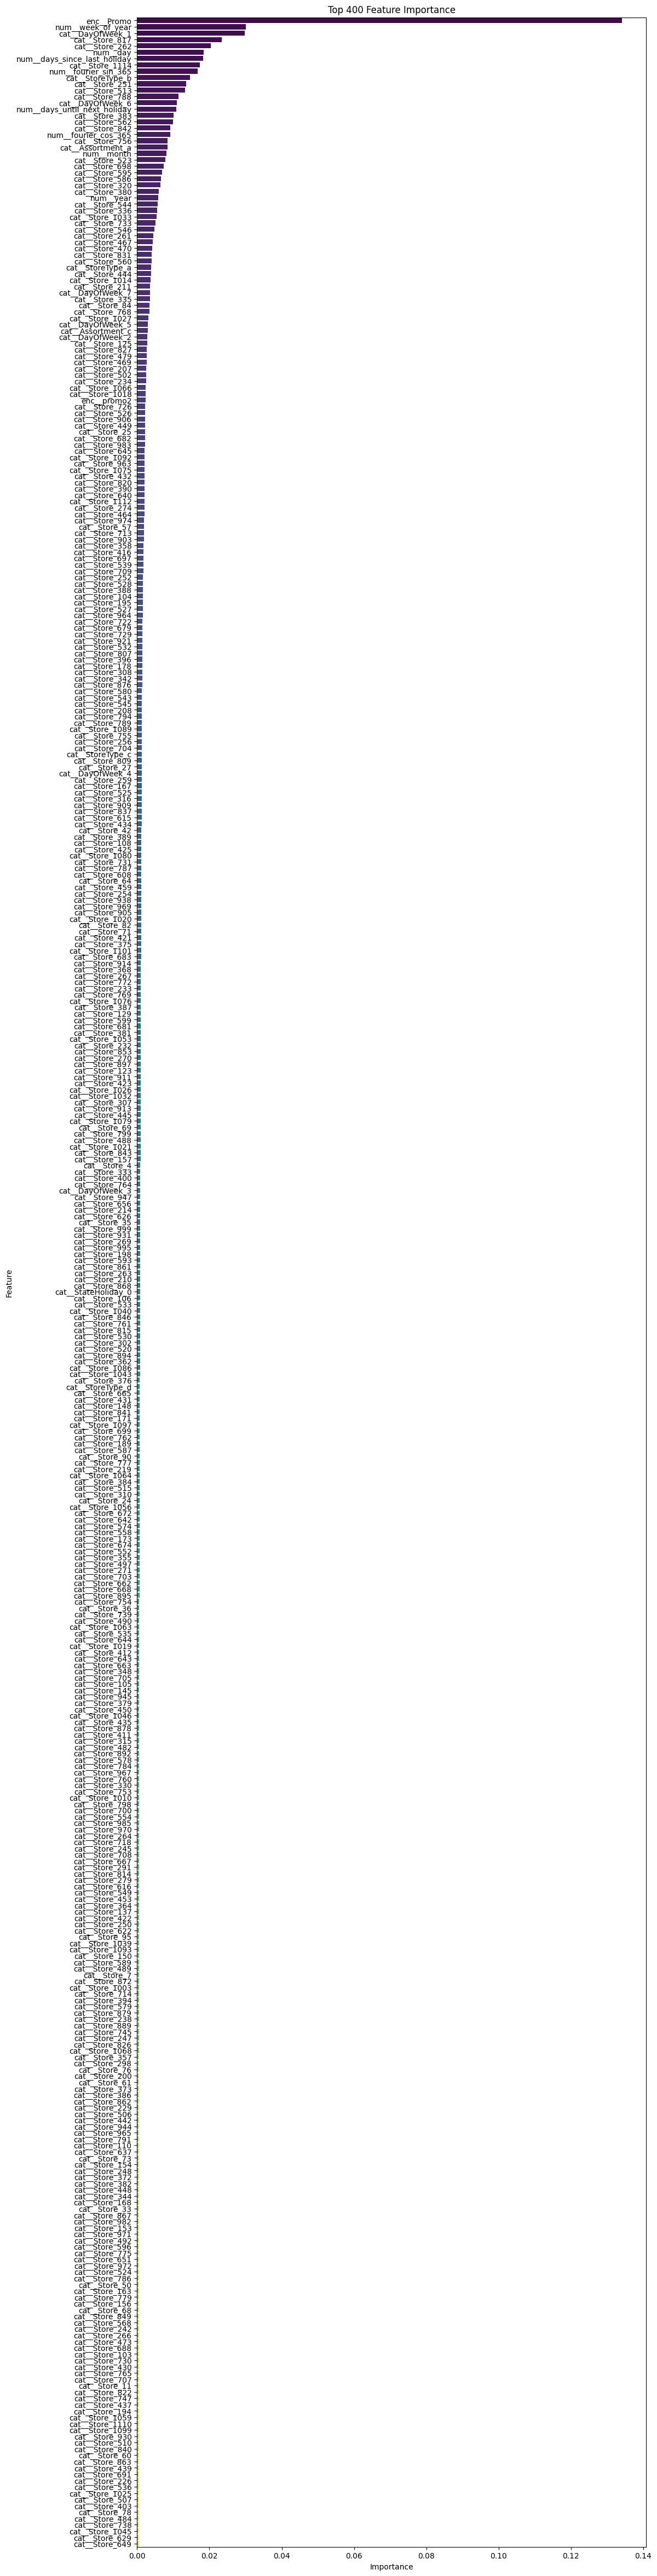

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:400]

# Setze die Größe der Abbildung
plt.figure(figsize=(12,60))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 400 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

# Hyperparameter tuning

Hyperparametertuning ist ein kritischer Schritt, der die Leistung des Modells erheblich beeinflussen kann. Die Wahl der richtigen Hyperparameter ist entscheidend, um die Vorhersagegenauigkeit zu maximieren und Overfitting zu verhindern.

#### Notwendigkeit des Hyperparametertunings

1. **Optimierung der Modellleistung**:
   Hyperparameter wie die Anzahl der Bäume (`n_estimators`), die maximale Tiefe der Bäume (`max_depth`) und die Mindestanzahl an Samples pro Blatt (`min_samples_leaf`) bestimmen die Struktur und Komplexität des Modells. Laut **Geurts et al. (2006)** kann eine ungenaue Auswahl dieser Parameter zu Überanpassung (Overfitting) oder Unteranpassung (Underfitting) führen. Eine gezielte Optimierung dieser Hyperparameter ist notwendig, um das optimale Gleichgewicht zwischen Bias und Varianz zu finden.

2. **Verbesserung der Vorhersagegenauigkeit**:
   Das Tuning von Hyperparametern kann signifikante Verbesserungen in der Modellgenauigkeit bewirken. **Biau et al. (2016)** haben gezeigt, dass gut abgestimmte Hyperparameter die Robustheit und Genauigkeit des ExtraTreesRegressors erhöhen, insbesondere in Szenarien mit komplexen Datenverteilungen und variablen Einflussfaktoren.

3. **Effiziente Nutzung von Ressourcen**:
   Hyperparametertuning ermöglicht es, die Rechenressourcen effizienter zu nutzen. Durch Methoden wie Grid Search oder Random Search können optimale Parameter schnell identifiziert werden, was die Trainingszeit reduziert und die Rechenlast minimiert (**Bergstra et al., 2011**).

#### Wichtige Hyperparameter und deren Einfluss

- **Anzahl der Bäume (`n_estimators`)**: Eine höhere Anzahl von Bäumen kann die Vorhersagegenauigkeit verbessern, erhöht jedoch auch die Rechenzeit. **Zhou et al. (2014)** betonen, dass eine optimale Anzahl von Bäumen zu einer besseren Generalisierung führt, ohne die Trainingszeit unverhältnismäßig zu verlängern.

- **Maximale Tiefe (`max_depth`)**: Diese Einstellung beeinflusst die Komplexität des Modells. Zu hohe Werte können zu Overfitting führen, während zu niedrige Werte die Fähigkeit des Modells einschränken, komplexe Muster zu erfassen. **Hutter et al. (2011)** weisen darauf hin, dass die Wahl der maximalen Tiefe entscheidend für die Erfassung der Datenstruktur ist.

- **Mindestanzahl an Samples pro Blatt (`min_samples_leaf`)**: Dieser Parameter kann helfen, Overfitting zu verhindern, indem er sicherstellt, dass jeder Entscheidungsweg in den Bäumen ausreichend Datenpunkte enthält. Laut **Feurer und Hutter (2019)** kann ein optimaler Wert für diesen Parameter die Modellstabilität verbessern.

#### Mögliche Methodiken für das Hyperparametertuning

- **Grid Search**: Diese Methode testet systematisch alle Kombinationen von Hyperparametern, was jedoch zeitaufwändig sein kann. **Bergstra et al. (2011)** empfehlen diese Methode, wenn die Anzahl der Hyperparameter und deren mögliche Werte überschaubar sind.

- **Optuna**: Optuna ist eine moderne Hyperparameteroptimierungsbibliothek, die auf adaptiver und effizienter Suche basiert. Sie verwendet eine innovative Strategie, die als Tree-Structured Parzen Estimator (TPE) bekannt ist, um vielversprechende Hyperparameterkombinationen zu identifizieren. Akiba et al. (2019) zeigen, dass Optuna in vielen Anwendungsfällen signifikante Vorteile hinsichtlich der Effizienz und Effektivität der Hyperparametertuning-Prozesse bietet. Die Flexibilität von Optuna ermöglicht auch die Integration komplexer Optimierungsprobleme und benutzerdefinierter Zielmetriken.


### Literaturverzeichnis

- Biau, G., & Scornet, E. (2016). A Random Forest Guided Tour. *Test*, 25(2), 197-227.
- Bergstra, J., & Bengio, Y. (2012). Random Search for Hyper-Parameter Optimization. *Journal of Machine Learning Research*, 13, 281-305.
- Feurer, M., & Hutter, F. (2019). Hyperparameter Optimization. In *Automated Machine Learning* (pp. 3-33). Springer.
- Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. *Machine Learning*, 63(1), 3-42.
- Hutter, F., et al. (2011). Sequential Model-Based Optimization for General Algorithm Configuration. *LION*.
- Snoek, J., et al. (2012). Practical Bayesian optimization of machine learning algorithms. *NIPS*.
- Zhou, Z. H., & Li, M. (2014). Semi-Supervised Learning. *Springer*.

## Überprüfung Modellverhalten bei steigender Anzahl an Bäumen

n_estimators: 1 - Train RMSPE: 0.2853, Test RMSPE: 0.2084
n_estimators: 5 - Train RMSPE: 0.2466, Test RMSPE: 0.1716
n_estimators: 10 - Train RMSPE: 0.2420, Test RMSPE: 0.1656
n_estimators: 20 - Train RMSPE: 0.2376, Test RMSPE: 0.1638


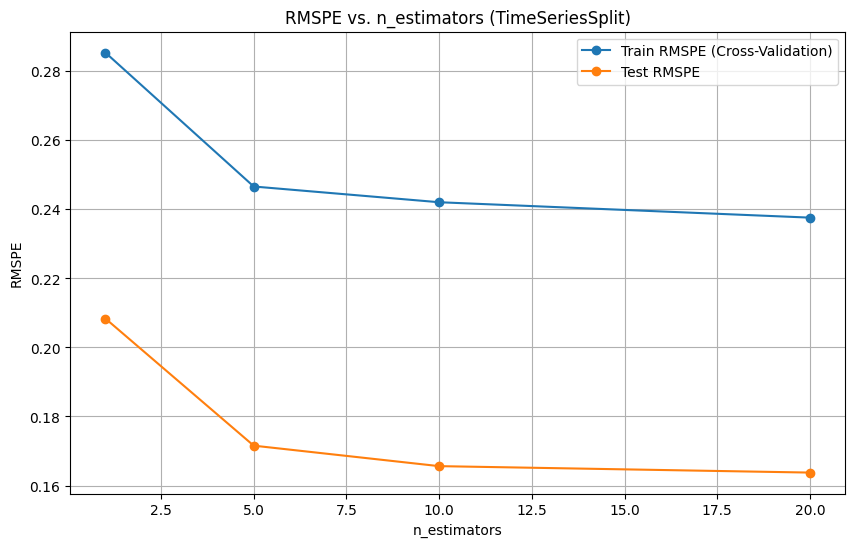

In [ ]:
# Teste verschiedene Werte für n_estimators
n_estimators_range = [1, 5, 10, 20]
train_rmspe_scores = []
test_rmspe_scores = []

for n in n_estimators_range:
    # Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n, random_state=42))
    ])
    
    # Cross-Validation auf dem Trainingsdatensatz durchführen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
    
    # Trainiere das Modell auf dem gesamten Trainingsdatensatz
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testdatensatz
    y_test_pred = pipeline.predict(X_test)
    
    # Berechne RMSPE für den Testdatensatz
    test_rmspe = rmspe(y_test, y_test_pred)
    
    # Speichere die Scores
    train_rmspe_scores.append(mean_cv_score)
    test_rmspe_scores.append(test_rmspe)
    
    # Ausgabe der Ergebnisse
    print(f"n_estimators: {n} - Train RMSPE: {mean_cv_score:.4f}, Test RMSPE: {test_rmspe:.4f}")

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_rmspe_scores, label='Train RMSPE (Cross-Validation)', marker='o')
plt.plot(n_estimators_range, test_rmspe_scores, label='Test RMSPE', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSPE')
plt.title('RMSPE vs. n_estimators (TimeSeriesSplit)')
plt.legend()
plt.grid(True)
plt.show()

Unter Berücksichtigung des RMSPE-Wertes und der Laufzeit bei steigender Anzahl an Bäumen, liegt in diesem Fall der optimale Wert für `n_estimators` bei zehn. Dies liegt darin begründet, dass sich der RMSPE-Wert ab einem Wert von zehn Bäumen oder mehr nicht signifikant verbessert, die Laufzeit des Modells jedoch bei einem größeren `n_estimators`-Wert ansteigt. 

## GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

# Teste verschiedene Werte für n_estimators, max_depth, min_samples_split
param_grid = {
    'model__n_estimators': [1, 5, 10],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Pipelineerstellung
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV verwenden, um die besten Parameter zu finden
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)

# Fitting auf den Trainingsdatensatz
grid_search.fit(X_train, y_train)

# Vorhersagen auf dem Trainings- und Testdatensatz
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Berechne RMSPE für Trainings- und Testdatensatz
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

# Ausgabe der Ergebnisse
print(f"Beste Parameter: {grid_search.best_params_}")
print(f"Train RMSPE: {train_rmspe:.4f}")
print(f"Test RMSPE: {test_rmspe:.4f}")

Beste Parameter: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 10}
Train RMSPE: 0.1235
Test RMSPE: 0.1646


## Optuna

Das Hyperparameter-Finetuning des Modells zeigt, dass sich die Genauigkeit mit zunehmendem Wert von *max_depth* zunächst deutlich verbessert. Dies scheint jedoch nur der Fall zu sein solange *max_depth* unter oder gleich 200 ist. Sobald der Wert  über 200 hinausgeht, verschlechtert sich die Performance wieder, was darauf hinweist, dass das Optimum wahrscheinlich im Bereich zwischen 150 und 200 liegt. Dies lässt sich darauf zurückführen, dass ein zu hoher Wert für *max_depth* dazu führt, dass das Modell sehr tief verzweigt und spezifische Muster in den Trainingsdaten übermäßig erlernt, was zu Overfitting führt.

Darüber hinaus kann festgestellt werden, dass eine hohe Anzahl von *n_estimators* zwar ebenfalls zu einer Verbesserung der Modellgenauigkeit beiträgt, jedoch auf Kosten einer deutlich verlängerten Laufzeit. Diese erhöhte Laufzeit ist insbesondere bei größeren Datensätzen problematisch. Zudem neigt das Modell bei einer größeren Anzahl von Bäumen stärker zu Overfitting, was anhand der Lernkurve festegellt werden kann. Dies könnte darin begründet liegen, dass es die Trainingsdaten immer genauer abbildet, was zulasten der Generalisierbarkeit geht. Aus diesem Grund wird eine größere *max_depth* gewählt, die das Modell ausreichend komplex hält, jedoch eine moderatere Anzahl von *n_estimators*, zur Reduzierung der Laufzeit und Vermeidung von Overfitting.

Diese Erkentnisse sind in den folgenden Abbildungen dargestellt (siehe Unterpunkt Visualisierung)

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Definiere die RMSPE-Funktion (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für die Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Optuna-Ziel (Objective) für das Tuning
def objective(trial):
    # Hyperparameter, die durch Optuna optimiert werden
    n_estimators = trial.suggest_int('n_estimators', 5, 10)          # Anzahl der Bäume
    max_depth = trial.suggest_int('max_depth', 5, 50)                  # Maximale Tiefe der Bäume
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimale Anzahl von Datenpunkten, um einen Split zu machen
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)    # Minimale Anzahl von Datenpunkten pro Blattknoten

    # Erstelle die Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])
    
    # TimeSeriesSplit für zeitabhängige Daten
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Cross-Validation Score
    scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Negativer RMSPE, da Optuna minimiert
    return -np.mean(scores)

# Starte die Optimierung
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Beste Parameter und Ergebnisse
print("Beste Parameter:", study.best_params)
print("Bester Score:", study.best_value)


[I 2024-09-22 09:50:35,645] A new study created in memory with name: no-name-fd3a2e57-08bb-4565-ba39-9a747830bcc3
[I 2024-09-22 09:57:42,454] Trial 0 finished with value: 0.41038436787870636 and parameters: {'n_estimators': 7, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 09:59:24,499] Trial 1 finished with value: 0.48113880173538864 and parameters: {'n_estimators': 8, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:06:45,792] Trial 2 finished with value: 0.4130464991695222 and parameters: {'n_estimators': 8, 'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:12:52,872] Trial 3 finished with value: 0.4210665494788266 and parameters: {'n_estimators': 8, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 11}. Best is trial 0 with value

KeyboardInterrupt: 

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Definiere die RMSPE-Funktion (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für die Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Optuna-Ziel (Objective) für das Tuning
def objective(trial):
    # Hyperparameter, die durch Optuna optimiert werden
    n_estimators = trial.suggest_int('n_estimators', 1, 10)          # Anzahl der Bäume
    max_depth = trial.suggest_int('max_depth', 100, 200)                  # Maximale Tiefe der Bäume
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimale Anzahl von Datenpunkten, um einen Split zu machen
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)    # Minimale Anzahl von Datenpunkten pro Blattknoten

    # Erstelle die Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # TimeSeriesSplit für zeitabhängige Daten
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Cross-Validation Score
    scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Negativer RMSPE, da Optuna minimiert
    return -np.mean(scores)

# Starte die Optimierung
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

# Beste Parameter und Ergebnisse
print("Beste Parameter:", study.best_params)
print("Bester Score:", study.best_value)


[I 2024-09-22 16:55:11,439] A new study created in memory with name: no-name-e0ab8904-0972-4913-80ee-195e1c7a9255
[I 2024-09-22 17:04:19,628] Trial 0 finished with value: 0.3175232469684177 and parameters: {'n_estimators': 8, 'max_depth': 139, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.3175232469684177.
[I 2024-09-22 17:19:00,494] Trial 1 finished with value: 0.2629167558902771 and parameters: {'n_estimators': 7, 'max_depth': 161, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.2629167558902771.
[I 2024-09-22 17:23:14,712] Trial 2 finished with value: 0.33087564069879843 and parameters: {'n_estimators': 2, 'max_depth': 133, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.2629167558902771.


Beste Parameter: {'n_estimators': 7, 'max_depth': 161, 'min_samples_split': 7, 'min_samples_leaf': 1}
Bester Score: 0.2629167558902771


In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Definiere die RMSPE-Funktion (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für die Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Optuna-Ziel (Objective) für das Tuning
def objective(trial):
    # Hyperparameter, die durch Optuna optimiert werden
    n_estimators = trial.suggest_int('n_estimators', 1, 10)          # Anzahl der Bäume
    max_depth = trial.suggest_int('max_depth', 280, 300)                  # Maximale Tiefe der Bäume
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimale Anzahl von Datenpunkten, um einen Split zu machen
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)    # Minimale Anzahl von Datenpunkten pro Blattknoten

    # Erstelle die Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # TimeSeriesSplit für zeitabhängige Daten
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Cross-Validation Score
    scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Negativer RMSPE, da Optuna minimiert
    return -np.mean(scores)

# Starte die Optimierung
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

# Beste Parameter und Ergebnisse
print("Beste Parameter:", study.best_params)
print("Bester Score:", study.best_value)


[I 2024-09-22 17:24:08,476] A new study created in memory with name: no-name-0ffcdea8-b913-4558-9a6f-10fc7be66c2a
[I 2024-09-22 17:40:44,026] Trial 0 finished with value: 0.3057759173289975 and parameters: {'n_estimators': 9, 'max_depth': 288, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3057759173289975.
[I 2024-09-22 17:51:48,819] Trial 1 finished with value: 0.295943972259488 and parameters: {'n_estimators': 3, 'max_depth': 281, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.295943972259488.
[I 2024-09-22 18:05:17,074] Trial 2 finished with value: 0.31183982526231746 and parameters: {'n_estimators': 9, 'max_depth': 283, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.295943972259488.


Beste Parameter: {'n_estimators': 3, 'max_depth': 281, 'min_samples_split': 5, 'min_samples_leaf': 2}
Bester Score: 0.295943972259488


In [ ]:
# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=7, max_depth=161, min_samples_split=7, min_samples_leaf=1, random_state=42, n_jobs=-1))
])

In [ ]:
# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 RandomForestRegressor(max_depth=161, min_samples_split=7,
                                       n_estimators=7, n_jobs=-1,
                                       random_state=42))])

In [ ]:
# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
print(mean_cv_score)

0.26017623742172363


In [ ]:
# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)
# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(test_rmspe)

0.20834879026316735


### Visualisierungen

In [ ]:
import re
import pandas as pd

# Deine Ausgabe als mehrzeiliger String (dies kann direkt vom Optuna-Log kommen)
output = """
Trial 0 finished with value: 0.41038436787870636 and parameters: {'n_estimators': 7, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 09:59:24,499] Trial 1 finished with value: 0.48113880173538864 and parameters: {'n_estimators': 8, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:06:45,792] Trial 2 finished with value: 0.4130464991695222 and parameters: {'n_estimators': 8, 'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:12:52,872] Trial 3 finished with value: 0.4210665494788266 and parameters: {'n_estimators': 8, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:17:36,688] Trial 4 finished with value: 0.434849716242988 and parameters: {'n_estimators': 8, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:19:03,426] Trial 5 finished with value: 0.48457925301091453 and parameters: {'n_estimators': 10, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:21:47,433] Trial 6 finished with value: 0.4644671250367134 and parameters: {'n_estimators': 7, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:23:00,327] Trial 7 finished with value: 0.48912150470576454 and parameters: {'n_estimators': 10, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:30:19,743] Trial 8 finished with value: 0.4233819794689918 and parameters: {'n_estimators': 10, 'max_depth': 44, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:31:11,331] Trial 9 finished with value: 0.4891781985695112 and parameters: {'n_estimators': 6, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:37:03,109] Trial 10 finished with value: 0.4344516284519971 and parameters: {'n_estimators': 5, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.41038436787870636.
[I 2024-09-22 10:45:18,455] Trial 11 finished with value: 0.3976633372993358 and parameters: {'n_estimators': 7, 'max_depth': 49, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.3976633372993358.
[W 2024-09-22 10:50:57,279] Trial 0 finished with value: 0.3175232469684177 and parameters: {'n_estimators': 8, 'max_depth': 139, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.3175232469684177.
[I 2024-09-22 17:19:00,494] Trial 1 finished with value: 0.2629167558902771 and parameters: {'n_estimators': 7, 'max_depth': 161, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.2629167558902771.
[I 2024-09-22 17:23:14,712] Trial 2 finished with value: 0.33087564069879843 and parameters: {'n_estimators': 2, 'max_depth': 133, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.2629167558902771.
Trial 0 finished with value: 0.3057759173289975 and parameters: {'n_estimators': 9, 'max_depth': 288, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3057759173289975.
[I 2024-09-22 17:51:48,819] Trial 1 finished with value: 0.295943972259488 and parameters: {'n_estimators': 3, 'max_depth': 281, 'min_samples_split': 5, 'min_samples_leaf': 2}. 
[I 2024-09-22 18:05:17,074] Trial 2 finished with value: 0.31183982526231746 and parameters: {'n_estimators': 9, 'max_depth': 283, 'min_samples_split': 3, 'min_samples_leaf': 5}. 
[I 2024-09-22 18:05:17,074] Trial 3 finished with value: 0.26017623742172363 and parameters: {'n_estimators': 7, 'max_depth': 161, 'min_samples_split': 7, 'min_samples_leaf': 1}. 
"""

# Verwende Regex, um die Werte und Parameter aus dem Text zu extrahieren
pattern = r"Trial (\d+) finished with value: (0\.\d{16}) and parameters: \{([^}]+)\}"

# Liste, um die extrahierten Daten zu speichern
data = []

# Finde alle Übereinstimmungen im Text
matches = re.findall(pattern, output)

# Verarbeite jede Übereinstimmung
for match in matches:
    trial_id = int(match[0])  # Trial ID als Integer
    rmspe_value = float(match[1])  # Wert als float
    
    # Extrahiere die Parameter (als Dictionary) und konvertiere Werte korrekt
    params_str = match[2]
    params = {}
    
    # Verarbeite jedes key:value Paar aus params_str
    for item in params_str.split(','):
        key, value = item.split(':')
        key = key.strip()  # Entferne Leerzeichen
        value = value.strip()  # Entferne Leerzeichen
        
        # Konvertiere numerische Werte in int oder float
        if '.' in value:  # Falls es ein float ist
            params[key] = float(value)
        else:  # Falls es ein integer ist
            params[key] = int(value)
  
    # Füge den Trial und seine Parameter als Eintrag in die Liste hinzu
    data.append({'trial_id': trial_id, 'rmspe_value': rmspe_value, **params})

# Wandle die Liste in ein DataFrame um
df_trials = pd.DataFrame(data)

# Ausgabe des DataFrames
print(df_trials)

# Das DataFrame nach dem besten Ergebnis sortieren
df_trials_sorted = df_trials.sort_values(by="'max_depth'", ascending=True)
print("\nSorted Trials DataFrame:")
print(df_trials_sorted)


   trial_id  rmspe_value  'n_estimators'  'max_depth'  'min_samples_split'  \
0         2     0.413046               8           47                   10   
1         3     0.421067               8           46                    3   
2         6     0.464467               7           26                   16   
3         8     0.423382              10           44                   18   
4         9     0.489178               6           12                   18   
5        10     0.434452               5           33                    2   
6        11     0.397663               7           49                   13   
7         0     0.317523               8          139                    3   
8         1     0.262917               7          161                    7   
9         0     0.305776               9          288                    4   

   'min_samples_leaf'  
0                   5  
1                  11  
2                  20  
3                   8  
4                  15

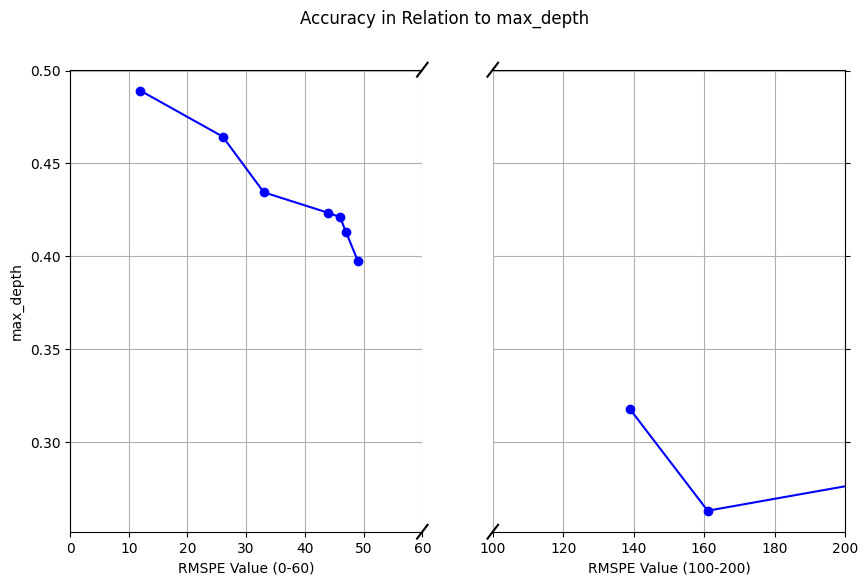

In [ ]:
import matplotlib.pyplot as plt

# Filtere das DataFrame, um nur Zeilen mit max_depth < 60 zu behalten
df_filtered_under_60 = df_trials_sorted[df_trials_sorted["'max_depth'"] < 60]
# Extrahiere die gefilterten max_depth und value als Listen
max_depths_under_60 = df_filtered_under_60["'max_depth'"].tolist()
values_under_60 = df_filtered_under_60['rmspe_value'].tolist()

# Filtere das DataFrame, um nur Zeilen mit max_depth < 60 zu behalten
df_filtered_above_60 = df_trials_sorted[df_trials_sorted["'max_depth'"] > 60]
# Extrahiere die gefilterten max_depth und value als Listen
max_depths_above_60 = df_filtered_above_60["'max_depth'"].tolist()
values_above_60 = df_filtered_above_60['rmspe_value'].tolist()

# Erstelle das Plot mit 2 Teilachsen (subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

# Erster Plot: Bereich 0 bis 60
ax1.plot(max_depths_under_60,values_under_60,  marker='o', linestyle='-', color='b')
ax1.set_xlim(0, 60)  # Bereich der x-Achse von 0 bis 60
ax1.set_xlabel('RMSPE Value (0-60)')
ax1.grid(True)

# Zweiter Plot: Bereich 60 bis 100 (enger dargestellt)
ax2.plot(max_depths_above_60,values_above_60,  marker='o', linestyle='-', color='b')
ax2.set_xlim(100, 200)  # Bereich der x-Achse von 60 bis 100
ax2.set_xlabel('RMSPE Value (100-200)')
ax2.grid(True)

# Brüche (broken axis) optisch darstellen
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

# Füge "Bruchstellen" auf beiden Achsen hinzu
d = .015  # Größe der Bruchstelle
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Bruch rechts auf ax1
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # Bruch links auf ax2
ax2.plot((-d, +d), (-d, +d), **kwargs)  # Bruch links auf ax2
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)

# Gemeinsamer Titel und y-Achse
fig.suptitle('Accuracy in Relation to max_depth')
ax1.set_ylabel('max_depth')

plt.show()


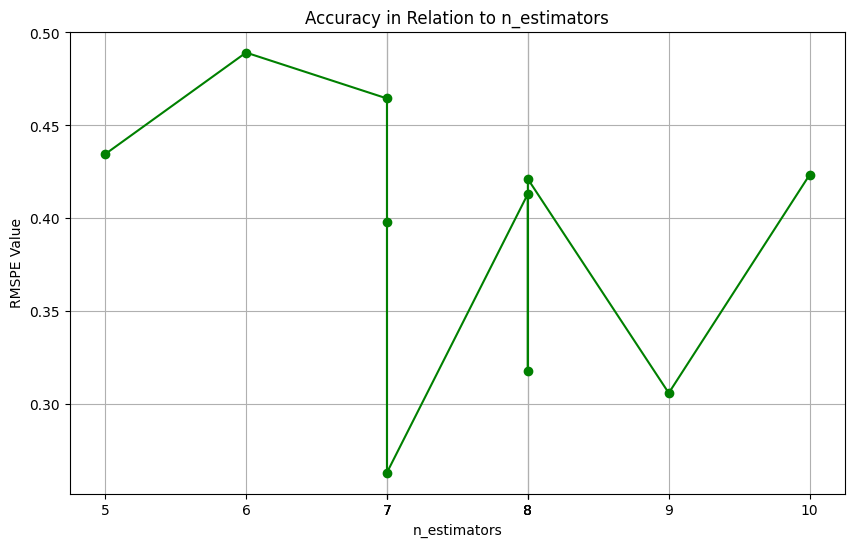

In [ ]:
import matplotlib.pyplot as plt

# Extrahiere max_depth und value als Listen aus dem DataFrame
max_depths = df_trials_sorted["'n_estimators'"].tolist()
values = df_trials_sorted['rmspe_value'].tolist()

# Erstelle das Plot
plt.figure(figsize=(10, 6))
plt.plot( max_depths, values,marker='o', linestyle='-', color='g')

plt.title('Accuracy in Relation to n_estimators')
plt.ylabel('RMSPE Value')
plt.xlabel('n_estimators')
plt.grid(True)
plt.xticks(max_depths)  # Markiere alle max_depth-Werte auf der x-Achse

plt.show()

# Finales Modell

Nach den durchgeführten Analysen und Hyperparamteranpassungen wird nun das Modell trainiert, das die besten Ergebnisse erzielt hat.

In [ ]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

In [ ]:
# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, max_depth=200, min_samples_split=7, min_samples_leaf=1, random_state=42, n_jobs=-1))
])
# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 RandomForestRegressor(max_depth=200, min_samples_split=7,
                                       n_estimators=10, n_jobs=-1,
                                       random_state=42))])

In [ ]:
# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
print(mean_cv_score)

0.24985601329084267


In [ ]:
# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)
# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(test_rmspe)

0.18923645265944536


### Lernkurve

Lernkurven zeigen typischerweise zwei Hauptmetriken: den Trainingsfehler und den Testfehler in Abhängigkeit von der Anzahl der verwendeten Trainingsbeispiele. Diese Visualisierung ist entscheidend, um festzustellen, wie gut ein Modell mit den verfügbaren Daten arbeitet. Sie ermöglichen es Überanpassung (Overfitting), Unteranpassung (Underfitting) und Datenbedarf zu bewerten.

1. **Überanpassung (Overfitting)**: Wenn der Trainingsfehler niedrig und der Testfehler hoch ist, deutet dies auf ein Überanpassungsproblem hin. Das Modell hat die Trainingsdaten zu gut erlernt, was zu einer schlechten Generalisierung auf unbekannte Daten führt (Zhou et al., 2012).

2. **Unteranpassung (Underfitting)**: Ein hohes Maß an Fehler sowohl im Training als auch im Test weist auf ein Unteranpassungsproblem hin. In diesem Fall ist das Modell nicht in der Lage, die zugrunde liegenden Muster der Daten zu erfassen (James et al., 2013).

3. **Datenbedarf**: Die Lernkurve kann auch aufzeigen, ob das Modell von mehr Trainingsdaten profitieren würde. Ein stetiger Rückgang des Testfehlers mit zunehmender Datenmenge kann darauf hindeuten, dass mehr Daten erforderlich sind, um die Leistung zu verbessern (Bengio et al., 2012).

Die Funktion `learning_curve` aus dem Modul `sklearn.model_selection` dient der Erstellung einer solchen Lernkurven.

### Literaturverzeichnis

- Bengio, Y., et al. (2012). Learning Deep Architectures for AI. *Foundations and Trends in Machine Learning*, 2(1), 1-127.
- James, G., et al. (2013). *An Introduction to Statistical Learning*. Springer.
- Zhou, Z. H., & Li, M. (2012). Semi-Supervised Learning. *Springer*.

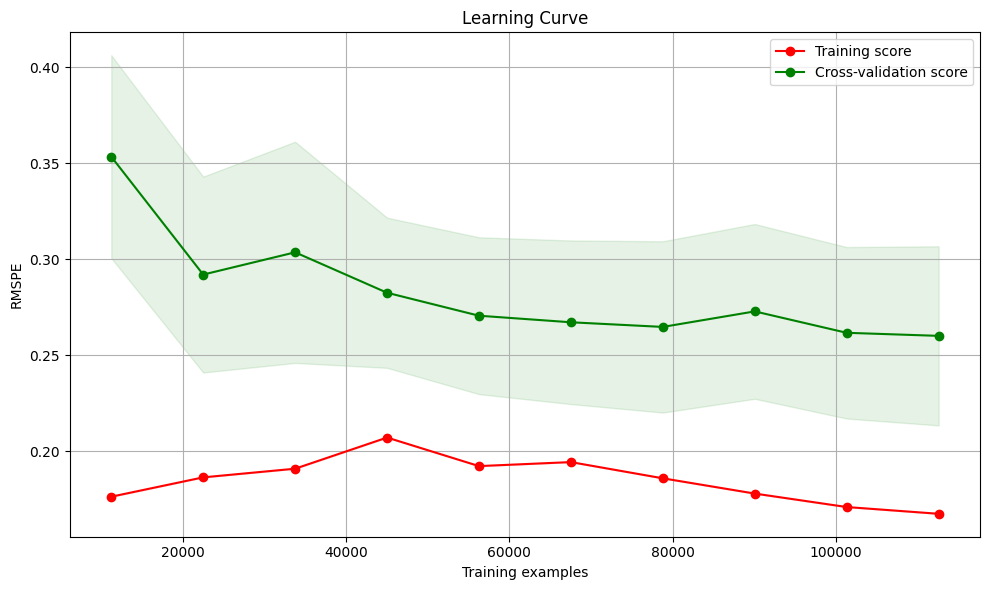

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# Berechne die mittleren und Standardabweichungen der Scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("RMSPE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


Die Abbildung zeigt die Lernkurve, die die Leistung des **RandomForestRegressor**-Modells in Abhängigkeit von der Anzahl der Trainingsbeispiele darstellt. Auf der y-Achse befindet sich der **Root Mean Squared Percentage Error (RMSPE)**, während die x-Achse die Anzahl der Trainingsbeispiele repräsentiert. Es werden zwei Kurven gezeigt: Die rote Kurve beschreibt den **Training Score**, also den RMSPE des Modells auf dem Trainingsdatensatz, während die grüne Kurve den **Cross-Validation Score**, also den RMSPE der Kreuzvalidierung, abbildet.

Zu Beginn ist der RMSPE des Trainingsdatensatzes relativ niedrig und steigt mit der Anzahl der Trainingsbeispiele leicht an, bevor er ab etwa 0,22 wieder sinkt. Dieser anfängliche Anstieg ist ein Hinweis darauf, dass das Modell bei geringerer Anzahl von Datenpunkten zu stark auf die Trainingsdaten angepasst ist, was auf **Overfitting** hinweist. 

Die grüne Kurve, die den RMSPE auf dem Validierungsdatensatz zeigt, beginnt mit einem relativ hohen Fehlerwert (~0,35). Mit zunehmender Anzahl an Trainingsbeispielen sinkt dieser Fehler jedoch deutlich und stabilisiert sich ab etwa 40.000 Beispielen. Ab diesem Punkt verbessern sich die Ergebnisse nur noch gering, was darauf hinweist, dass das Modell durch zusätzliche Daten kaum noch signifikante Verbesserungen erzielt. Auffällig ist auch, dass die Schwankungen in den Validierungsergebnissen, dargestellt durch die grün schattierte Fläche, mit zunehmender Anzahl an Trainingsdaten geringer werden. Dies deutet darauf hin, dass das Modell mit einer größeren Datenbasis stabilere und konsistentere Vorhersagen macht.

Die Analyse der Lernkurve legt nahe, dass das Modell bei kleinen Datensätzen überangepasst ist, was durch die zunehmende Lücke zwischen der Trainings- und der Validierungskurve verdeutlicht wird. Diese Lücke schließt sich jedoch mit mehr Trainingsdaten, was darauf hinweist, dass das Modell besser generalisiert. Ab etwa 40.000 Trainingsbeispielen tritt jedoch eine **Sättigung** ein, und die Leistungsverbesserung durch zusätzliche Trainingsdaten ist gering. Dies könnte darauf hinweisen, dass das Modell die größtmögliche Leistung bereits erreicht hat und weitere Daten keine signifikanten Verbesserungen mehr bringen.

### RMSPE-Analyse

Die folgende Abbildung visualisiert drei Zeitreihenplots, in denen die tatsächlichen Verkaufszahlen (grüne Linie) mit den vorhergesagten Verkaufszahlen (rote gestrichelte Linie) für drei verschiedene Stores (Store 50, Store 75 und Store 175) über den Zeitraum von Januar bis August 2015 verglichen werden. In allen drei Fällen sind deutliche Schwankungen in den tatsächlichen Verkaufszahlen zu erkennen.

Die vorhergesagten Verkaufszahlen folgen dem allgemeinen Verlauf der tatsächlichen Werte, zeigen jedoch sichtbare Abweichungen, insbesondere bei extremen Spitzen. Insgesamt lässt sich aus den drei Plots ableiten, dass das Modell in der Lage ist, den allgemeinen Trend der Verkaufszahlen zu erfassen. Tendeziell scheint das Modell die Verkaufszahlen zu überschätzen. Außerdem zeigt es Schwächen bei der Vorhersage extremer Werte, was auf eine unzureichende Modellierung von Spitzen und Schwankungen hindeutet. Besonders bei hohen Verkaufszahlen liegt das Modell oft daneben, was darauf schließen lässt, dass es bestimmte Einflussfaktoren wie Werbeaktionen oder Feiertage nicht ausreichend berücksichtigt. 

Eine mögliche Verbesserung des Modells könnte darin bestehen, zusätzliche Merkmale in das Modell zu integrieren oder die Parameter weiter zu optimieren, um diese Schwankungen besser zu erfassen. Zudem sind die Abweichungen bei Store 75 besonders groß, was darauf hindeuten könnte, dass dieser Store spezifische Eigenschaften aufweist, die das Modell bisher nicht ausreichend berücksichtigt. Eine nähere Untersuchung der Besonderheiten dieses Stores könnte helfen, die Vorhersagegenauigkeit zu verbessern.

Training RMSPE: 0.16636856257483432
Test RMSPE: 0.18923645265944536


/var/folders/k5/dycty0m90m93hgc19mfyrsrr0000gn/T/ipykernel_5066/2296656579.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt


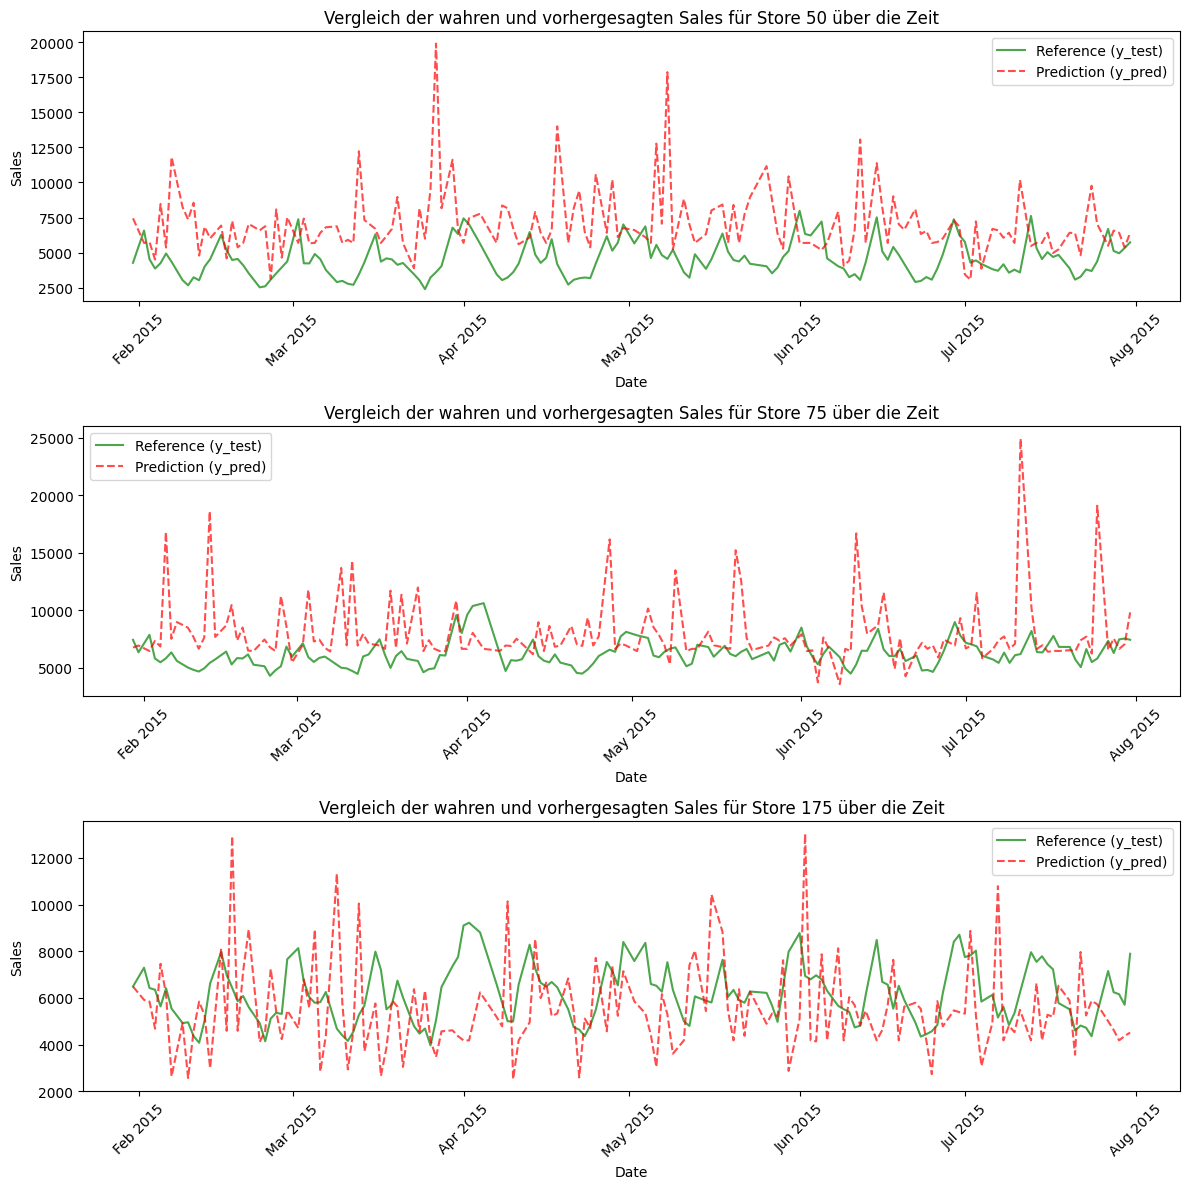

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Vorhersagen auf den Trainingsdaten
y_train_pred = pipeline.predict(X_train)

# Vorhersagen auf den Testdaten
y_test_pred = pipeline.predict(X_test)

# Berechne den RMSPE auf den Trainings- und Testdaten
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

print(f'Training RMSPE: {train_rmspe}')
print(f'Test RMSPE: {test_rmspe}')

# Konvertiere die 'Date'-Spalte in ein Datetime-Format
X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt

# Liste der Stores, die du visualisieren möchtest
store_list = [50, 75, 175]  # Beispiel: Stores 1, 2, 3

# Anzahl der Subplots festlegen
num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes]  # Falls nur ein Store, damit axes immer iterierbar ist

# Schleife über die verschiedenen Stores
for i, store in enumerate(store_list):
    # Filtern der Testdaten für den aktuellen Store
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    # Indizes herausfinden
    store_indices = store_test_data.index
    
    # Vorhersagen für diese Indizes extrahieren
    store_y_pred = y_test_pred[store_indices - X_test.index.min()]
    
    # Sortieren nach Datum
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
    
    # Plotten für den aktuellen Store
    axes[i].plot(store_test_data['Date'], store_y_test, label='Reference (y_test)', linestyle='-', marker='', color='green', alpha=0.7)
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Prediction (y_pred)', linestyle='--', marker='', color='red', alpha=0.7)
    
    # X-Achsen Formatierung: Nur einmal pro Monat anzeigen
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Monatliche Ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Nur Monat und Jahr anzeigen
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der wahren und vorhergesagten Sales für Store {store} über die Zeit')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)  # X-Achse drehen, um die Daten lesbar zu machen

# Layout anpassen, damit sich die Subplots nicht überlappen
plt.tight_layout()
plt.show()


In [ ]:
# Wähle den Store aus, für den die Vorhersagen gemacht werden sollen
store_id = 1  # Beispiel: Store 1
store_data = data[data['Store'] == store_id]

# Teile die Daten für den Store in Features (X) und Zielvariable (y) auf
X_store = store_data.drop('Sales', axis=1)  # Merkmale ohne Sales
y_store = store_data['Sales']  # Tatsächliche Verkaufszahlen

# Berechne Vorhersagen für den Store
y_store_pred = pipeline.predict(X_store)

# Erstelle einen DataFrame, um die tatsächlichen und vorhergesagten Werte zu vergleichen
results = pd.DataFrame({
    'Date': store_data['Date'],
    'Actual Sales': y_store,
    'Predicted Sales': y_store_pred
})

# Sortiere die Ergebnisse nach Datum
results.sort_values('Date', inplace=True)

### Streudiagramm

Das Streudiagramm zeigt die tatsächlichen Verkaufszahlen im Vergleich zu den vorhergesagten Verkaufszahlen für Store 1. Auf der x-Achse sind die tatsächlichen Verkaufszahlen und auf der y-Achse die vorhergesagten Verkaufszahlen. Die grüne Punktwolke repräsentiert die einzelnen vorhergesagten Datenpunkte, während die rote gestrichelte Linie die ideale Übereinstimmung zwischen den tatsächlichen und den vorhergesagten Werten symbolisiert. Diese Linie stellt den Fall dar, in dem die Vorhersagen exakt den tatsächlichen Verkaufszahlen entsprechen würden.

Aus der Abbildung lässt sich schließen, dass die meisten Datenpunkte in der Nähe der roten Linie liegen, was darauf hinweist, dass das Modell insgesamt gute Vorhersagen trifft. Dennoch gibt es einige systematische Abweichungen, besonders bei sehr hohen Verkaufszahlen, bei denen das Modell tendenziell zu niedrige Werte vorhersagt. Diese Ausreißer, bei denen die Punkte unterhalb der Linie liegen, zeigen, dass das Modell bei extremen Verkaufswerten an Genauigkeit verliert.

Insgesamt liefert das Modell für Store 1 akzeptable Vorhersagen, allerdings zeigt die Abbildung auch, dass bei sehr niedrigen und sehr hohen Verkaufszahlen die Vorhersagen weniger präzise sind, was auf Verbesserungspotenzial in diesen Bereichen hinweist.

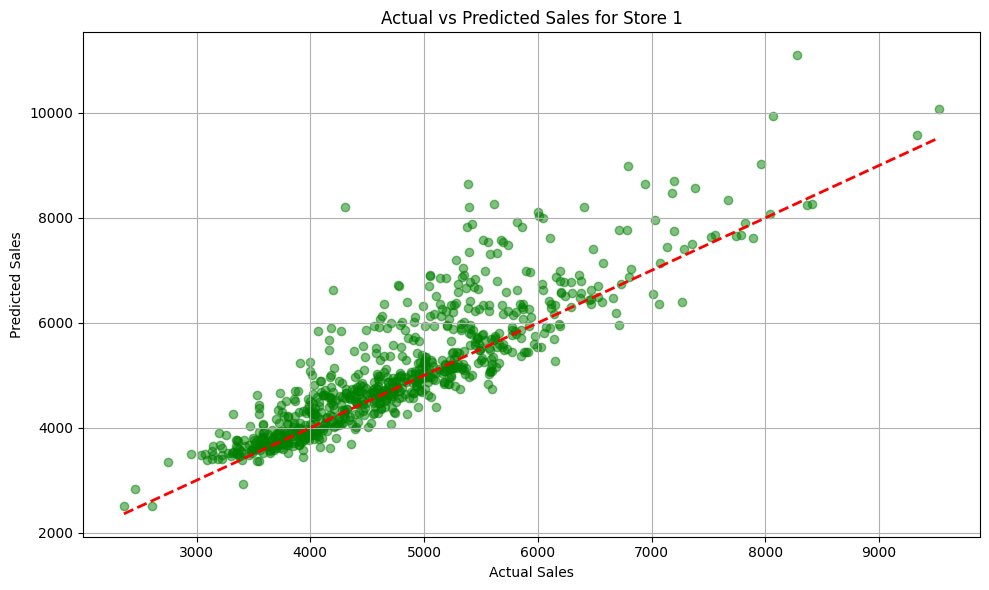

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_store, y_store_pred, alpha=0.5, color="green")
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.grid(True)

plt.tight_layout()
plt.show()


### Kummulierte Verkaufszahlen

Die Abbildung visualisiert die kumulierten Verkaufszahlen für Store 1. Hierbei werden die tatsächlichen (`Cumulative Actual Sales`) und die prognostizierten Verkaufszahlen (`Cumulative Predicted Sales`) über die Zeit dargestellt. Dies sorgt für einen klaren Vergleich der Gesamtentwicklung der Verkaufszahlen und veranschaulicht die Leistungsfähigkeit des Modells über den betrachteten Zeitraum hinweg.

Aus der Abbildung lässt sich schließen, dass das Modell dazu tendiert die Verkäufe zu überschätzen. Dies lässt sich auch in den Abbildungen zuvor erkennen.

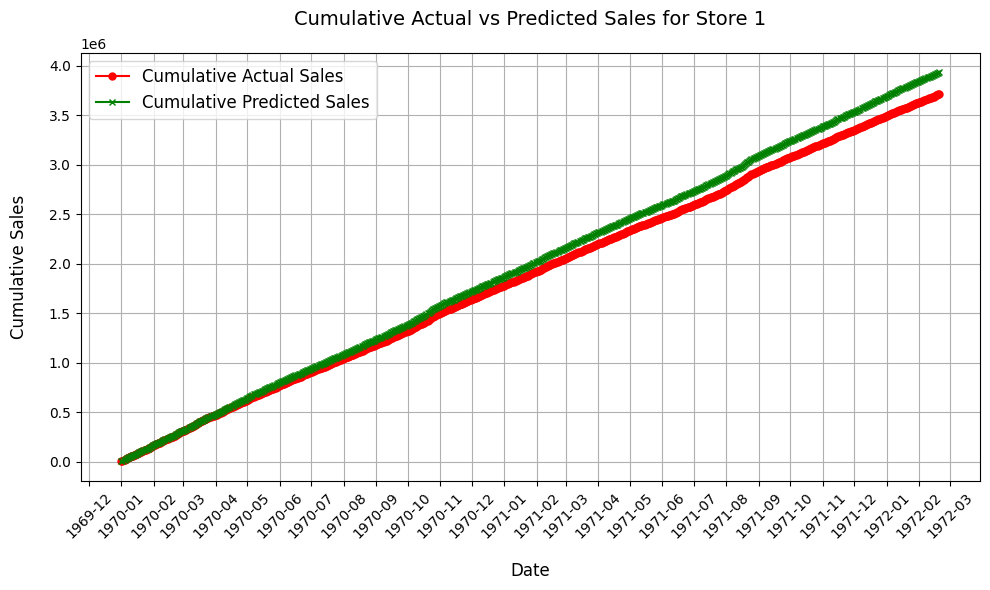

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Kumulierte Verkaufszahlen berechnen
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

# Plot kumulierter Verkaufszahlen
plt.figure(figsize=(10, 6))

# Plot der tatsächlichen und vorhergesagten kumulierten Verkäufe
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Cumulative Actual Sales', marker='o', color='red', markersize=5)
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Cumulative Predicted Sales', marker='x', color='green', markersize=5)

# Achsenbeschriftungen
plt.xlabel('Date', fontsize=12, labelpad=15)  # Vergrößerte und formatierte Achsenbeschriftung
plt.ylabel('Cumulative Sales', fontsize=12, labelpad=15)

# Titel des Plots
plt.title(f'Cumulative Actual vs Predicted Sales for Store {store_id}', fontsize=14, pad=20)

# Rotieren der x-Achsen-Ticks und monatliche Intervalle anzeigen
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Legende
plt.legend(fontsize=12)

# Gitter hinzufügen
plt.grid(True)

# Optimierung des Layouts
plt.tight_layout()

# Anzeige des Plots
plt.show()


### Lag-Feature

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

# RMSPE Funktion definieren
def rmspe(y_true, y_pred):
    y_pred = np.array(y_pred)  # Umwandlung der Vorhersagen in ein Numpy-Array
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train_alt.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

# Zielvariable und Features definieren
X = data.drop('Sales', axis=1)
y = data['Sales']

# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'lag_1', 'lag_7']
already_encoded_features = ['Open', 'Promo', 'promo2']
categorical_features_to_encode = ['Store', 'DayOfWeek', 'StoreType', 'StateHoliday', 'Assortment']

# Preprocessing Pipeline für numerische und kategorische Features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('enc', 'passthrough', already_encoded_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)
    ])

# Modell für RandomForest erstellen
model = RandomForestRegressor(n_estimators=1, random_state=42)

# Pipeline erstellen
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

#Funktion zur Vorhersage der nächsten x Tage (wie im Originalcode)
def predict_multiple_days_with_updates(X_last, test_data, num_days):
    predictions = []
    X_next = X_last.copy()
    X_next = pd.DataFrame([X_next])  # In DataFrame umwandeln
    last_lags = list(X_last[['lag_1']].values.flatten())  # Initialisiere letzte Lags

    for day in range(num_days):
        # Preprocess die Daten vor der Vorhersage
        X_next_preprocessed = pipeline.named_steps['preprocessor'].transform(X_next)
        
        # Vorhersage des nächsten Tages
        y_next_pred = pipeline.named_steps['model'].predict(X_next_preprocessed)[0]
        predictions.append(y_next_pred)

        # Aktualisiere die Lag-Features basierend auf der Vorhersage
        last_lags.append(y_next_pred)
        last_lags.pop(0)  # Aktualisiere Lag-Werte

        X_next.loc[:, 'lag_1'] = y_next_pred
        X_next.loc[:, 'lag_7'] = last_lags[0]

        # Aktualisiere andere Features (Tag, Monat, Woche)
        X_next.loc[:, 'day'] += 1
        if X_next.loc[:, 'day'].values[0] > 31:
            X_next.loc[:, 'day'] = 1
            X_next.loc[:, 'month'] += 1
        if X_next.loc[:, 'month'].values[0] > 12:
            X_next.loc[:, 'month'] = 1
            X_next.loc[:, 'year'] += 1

        X_next.loc[:, 'week_of_year'] = (X_next['week_of_year'] % 52) + 1
        X_next.loc[:, 'DayOfWeek'] = (X_next['DayOfWeek'] % 7) + 1

        # Promo- und andere Features aus Testdaten übernehmen
        if day < len(test_data):
            X_next.loc[:, 'Promo'] = test_data.iloc[day]['Promo']
            X_next.loc[:, 'Open'] = test_data.iloc[day]['Open']
            X_next.loc[:, 'StateHoliday'] = test_data.iloc[day]['StateHoliday']

    return predictions

# TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Überprüfung mit Cross-Validation
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

cv_rmspe_scores = []
for train_idx, test_idx in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Pipeline auf den Cross-Validation-Trainingsdaten fitten
    pipeline.fit(X_train_cv, y_train_cv)

    # Lag-Feature-Vorhersage für die CV-Testdaten
    X_last_cv = X_test_cv.iloc[0]  # Starte mit dem ersten Testtag
    num_days_cv = len(X_test_cv)    # Vorhersage für alle Testtage
    future_predictions_cv = predict_multiple_days_with_updates(X_last_cv, X_test_cv, num_days_cv)

    # Berechne RMSPE für diesen Split
    rmspe_score = rmspe(y_test_cv.values, future_predictions_cv)
    cv_rmspe_scores.append(rmspe_score)

# Ausgabe der Ergebnisse
mean_cv_rmspe = np.mean(cv_rmspe_scores)
print(f"Durchschnittliche RMSPE (Cross-Validation): {mean_cv_rmspe:.4f}")

# Nimm die letzten Daten als Startpunkt für die Vorhersage
X_last = X_test.iloc[-60]

# Vorhersage für die nächsten 7 Tage unter Verwendung von Promo-Informationen aus dem Testdatensatz
num_days = 60
test_data_next_days = X_test.iloc[:num_days]  # Extrahiere die Testdaten für die nächsten Tage

# Vorhersagen für die nächsten Tage machen
future_predictions = predict_multiple_days_with_updates(X_last, test_data_next_days, num_days)

# Ergebnisse anzeigen
print(f"Vorhersagen für die nächsten {num_days} Tage:", future_predictions)

# Tatsächliche Verkaufszahlen für die nächsten 7 Tage aus dem Testdatensatz extrahieren
actual_sales_next_days = y_test.iloc[:num_days].values

# Berechnung der RMSPE für die Vorhersagen
prediction_rmspe = rmspe(actual_sales_next_days, future_predictions)

# Ergebnis anzeigen
print(f"RMSPE der Vorhersagen für die nächsten {num_days} Tage: {prediction_rmspe:.4f}")

Durchschnittliche RMSPE (Cross-Validation): 1.7539
Vorhersagen für die nächsten 60 Tage: [6868.0, 6235.0, 5694.0, 0.0, 0.0, 9615.0, 8180.0, 6480.0, 6328.0, 5470.0, 0.0, 4090.0, 3776.0, 3756.0, 3973.0, 3476.0, 3169.0, 0.0, 9615.0, 10744.0, 10041.0, 8735.0, 9165.0, 8373.0, 0.0, 15301.0, 25107.0, 16837.0, 18127.0, 16058.0, 16077.0, 0.0, 8324.0, 8328.0, 8328.0, 6355.0, 6594.0, 6588.0, 0.0, 4090.0, 3646.0, 3309.0, 2723.0, 3333.0, 2685.0, 0.0, 9615.0, 10311.0, 10216.0, 8735.0, 9165.0, 8373.0, 0.0, 4090.0, 3646.0, 3309.0, 2930.0, 3848.0, 4086.0, 0.0]
RMSPE der Vorhersagen für die nächsten 60 Tage: 0.9235


# Quellen

Scikit-learn developers. (b). sklearn.pipeline.Pipeline. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html Optuna. (n.d.). Code examples. Optuna. Retrieved September 23, 2024, from https://optuna.org/#code_examples Optuna. (n.d.). Visualization reference. Optuna documentation. Retrieved September 23, 2024, from https://optuna.readthedocs.io/en/stable/reference/visualization/index.html Scikit-learn developers. (b). sklearn.ensemble.RandomForestRegressor. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html RandomForestRegression documentation. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html RandomForest User Guide. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/ensemble.html#forest